In [1]:
library(tidyverse)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



# Generate Simulated Data Set

In [2]:
library(tidyverse)
library(caret)

In [3]:
#library(devtools)
#install_github("theodds/SoftBART")

## Functions used to generate fake data
set.seed(42)
f_fried <- function(x) 10 * sin(pi * x[,1] * x[,2]) + 20 * (x[,3] - 0.5)^2 + 
  10 * x[,4] + 5 * x[,5]

our_function <- function(x) sin(x[,1])*exp(x[,2])*10 + cos(2*x[,3]) - 20*x[,4]^2 + 3*x[,5]^3 - 15*x[,6]^(1/3) 

high_dimensional_func <- function(x) 10 * sin(pi * apply(x[,1:200], 1, prod)) + 20 * (apply(x[,201:300],1,sum) - 5)^2 + 
  10 * apply(x[,301:400],1,sum) + 5 * apply(x[,401:500],1,sum)

gen_data <- function(n_train, n_test, func, P, sigma, a, b) {
  X <- matrix(runif(n_train * P, a, b), nrow = n_train)
  mu <- func(X)
  X_test <- matrix(runif(n_test * P, a, b), nrow = n_test)
  mu_test <- func(X_test)
  Y <- mu + sigma * rnorm(n_train)
  Y_test <- mu_test + sigma * rnorm(n_test)
  
  return(list(X = X, Y = Y, mu = mu, X_test = X_test, Y_test = Y_test, mu_test = mu_test))
}


set.seed(42)
#all 500 predictors do have a relationship to y, and p > n
sim_data_high_dim <- gen_data(250, 100, high_dimensional_func, 500, 1, 0, 1)
sim_data <- sim_data_high_dim

In [4]:
sim_data$X %>% head
sim_data$Y %>% head

0.9148060,0.33423133,0.1365052,0.24492099,0.84829322,0.73592037,0.05391100,0.1651787,0.9899656,0.24640458,⋯,0.99427294,0.7423870,0.72410687,0.16582872,0.2326665,0.4323665,0.88768936,0.2056952,0.7571951,0.28780657
0.9370754,0.18843433,0.1771364,0.08763591,0.06274633,0.75178575,0.95509577,0.7277811,0.4384936,0.02302811,⋯,0.06966940,0.9547126,0.49973936,0.37820132,0.3646830,0.8549922,0.44734078,0.7106295,0.1809865,0.26822268
0.2861395,0.26971618,0.5195605,0.39110850,0.81984509,0.33261448,0.02560094,0.2061579,0.6999032,0.28421418,⋯,0.04320362,0.6666864,0.43107205,0.09545684,0.8591651,0.8267867,0.07004356,0.9331143,0.1791534,0.88956639
0.8304476,0.53074408,0.8111208,0.18256143,0.53936029,0.05754862,0.92076314,0.5864655,0.8890770,0.81289268,⋯,0.27283225,0.2487890,0.02452249,0.09963018,0.6486600,0.5641049,0.20832449,0.2310083,0.2310819,0.03190875
0.6417455,0.02145023,0.1153620,0.13362478,0.49902010,0.67441545,0.36666474,0.9135460,0.8341595,0.71891839,⋯,0.64295571,0.2757056,0.18624315,0.76918417,0.7825161,0.5704042,0.10296584,0.6558101,0.8031555,0.08497604
0.5190959,0.79876031,0.8934218,0.25746291,0.02222732,0.04157017,0.69839255,0.2069666,0.7344215,0.52957674,⋯,0.82524866,0.4466356,0.61867453,0.60448438,0.8199726,0.3800179,0.22248305,0.9631550,0.2135561,0.98446287


[1] 42485.16 35348.83 45613.73 31813.80 36441.17 38568.35

# BART with 500 Predictors, 500 important

In [4]:
options(java.parameters = "-Xmx8g")
library(bartMachine)

Loading required package: rJava
Loading required package: bartMachineJARs
Loading required package: car
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some

Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: missForest
Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: itertools
Loading required package: iterators
Welcome to bartMachine v1.2.3! You have 7.64GB memory available.

If you run out of memory, restart R, and use e.g.
'options(java.parameters = "-Xmx5g")' for 5GB of RAM b

In [5]:
#Include the parallel library. If the next line does not work, run install.packages(“parallel”) first
library(parallel)
library(doParallel)

# Use the detectCores() function to find the number of cores in system
n_cores <- detectCores()
print(n_cores)
cl <- makePSOCKcluster(n_cores)
#registerDoParallel(cl)
#stopCluster(cl)

[1] 16


In [6]:
set_bart_machine_num_cores(n_cores)

bartMachine now using 16 cores.


In [7]:
t.start <- Sys.time()
sim.bm <- bartMachine(X = sim_data$X %>% data.frame, y = sim_data$Y,
            verbose = TRUE, 
            serialize =  TRUE)
t.final <- Sys.time() - t.start
print(t.final)

bartMachine initializing with 50 trees...
bartMachine vars checked...
bartMachine java init...
bartMachine factors created...
bartMachine before preprocess...
bartMachine after preprocess... 501 total features...
bartMachine sigsq estimated...
bartMachine training data finalized...
Now building bartMachine for regression ...
evaluating in sample data...done
serializing in order to be saved for future R sessions...done
Time difference of 4.009215 secs


In [13]:
k_fold_sim <- k_fold_cv(X = sim_data$X %>% data.frame, y = sim_data$Y,)

.....


In [14]:
k_fold_sim$rmse

[1] 4901.751

In [15]:
sim.bm %>% summary

bartMachine v1.2.3 for regression

training data n = 250 and p = 500 
built in 3.2 secs on 16 cores, 50 trees, 250 burn-in and 1000 post. samples

sigsq est for y beforehand: 29411509.568 
avg sigsq estimate after burn-in: 10855146.35117 

in-sample statistics:
 L1 = 432602.16 
 L2 = 1171607627.71 
 rmse = 2164.82 
 Pseudo-Rsq = 0.84
p-val for shapiro-wilk test of normality of residuals: 0.00769 
p-val for zero-mean noise: 0.75056 



In [16]:
rmse <- function(actual, predicted){
    sqrt(mean((actual-predicted)^2))
}

In [17]:
rmse(sim_data$Y, predict(sim.bm, sim_data$X %>% data.frame)) #insample
rmse(sim_data$Y_test, predict(sim.bm, sim_data$X_test %>% data.frame)) #out of sample

[1] 2164.817

[1] 4562.308

In [18]:
sim.bm %>% check_bart_error_assumptions

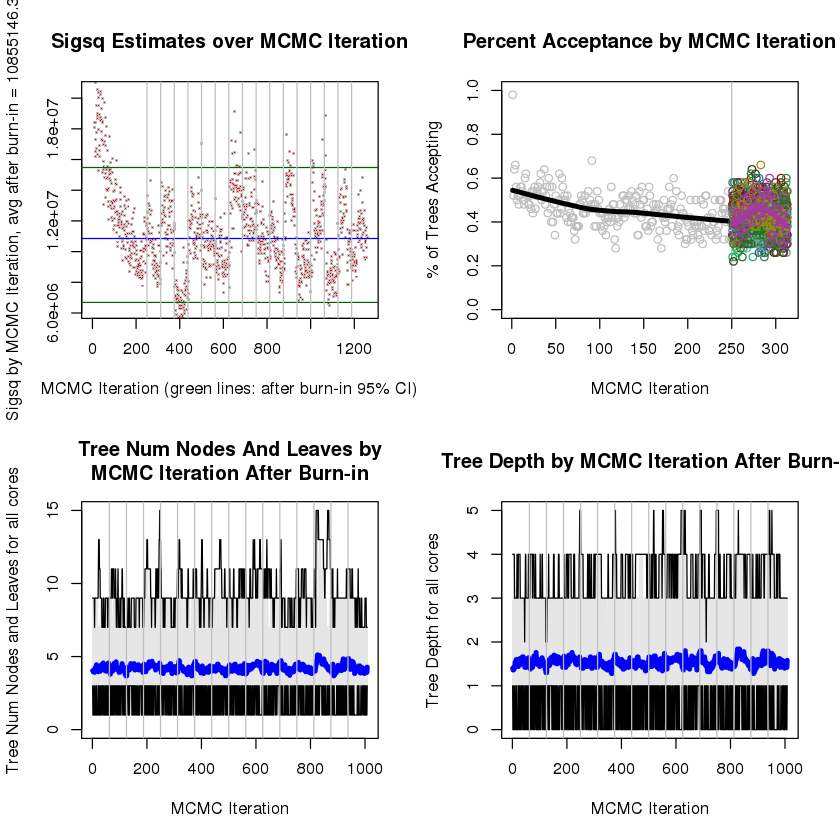

In [19]:
sim.bm %>% plot_convergence_diagnostics

....................


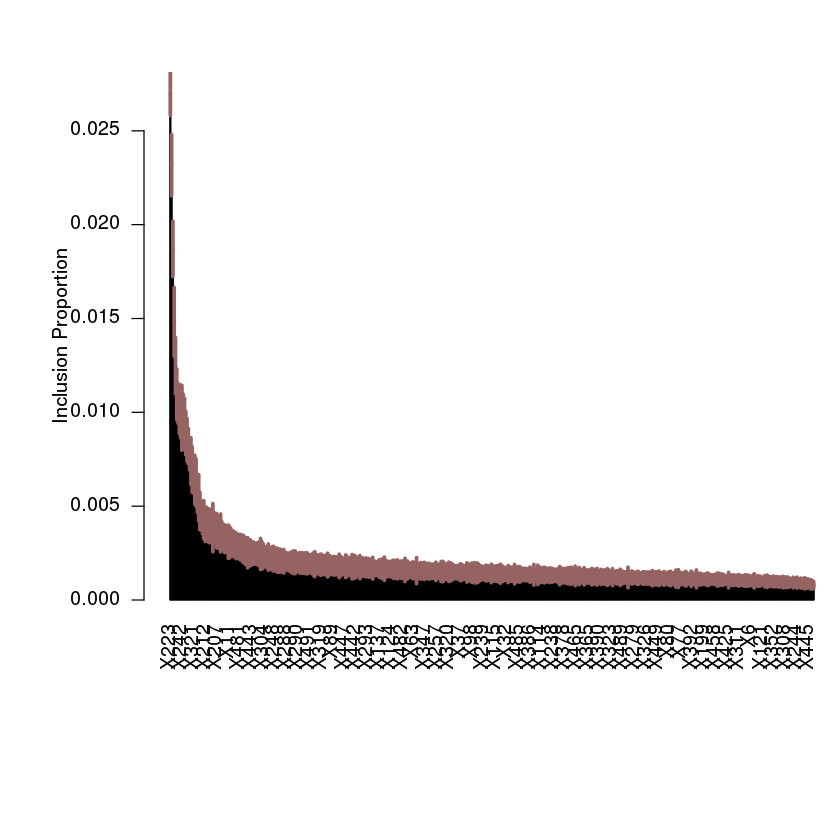

In [20]:
investigate_var_importance(sim.bm, num_replicates_for_avg = 20)

In [21]:
saveRDS(sim.bm,"model_files/simbm_highdim_model_v1_20191124.RDS")
sim.bm.read <- readRDS("model_files/simbm_highdim_model_v1_20191124.RDS")
sim.bm <- sim.bm.read

# DART with 500 Predictors, 5 important

In [5]:
options(java.parameters = "-Xmx8g")
library(dartMachine)

Loading required package: rJava
Loading required package: car
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some

Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: missForest
Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: itertools
Loading required package: iterators
Welcome to bartMachine v1.2.0! You have 7.64GB memory available.



In [6]:
#Include the parallel library. If the next line does not work, run install.packages(“parallel”) first
library(parallel)
library(doParallel)

# Use the detectCores() function to find the number of cores in system
n_cores <- detectCores()
print(n_cores)
cl <- makePSOCKcluster(n_cores)
#registerDoParallel(cl)
#stopCluster(cl)

[1] 16


In [7]:
set_bart_machine_num_cores(n_cores)

bartMachine now using 16 cores.


In [8]:
t.start <- Sys.time()
sim.dartmachine <- bartMachine(X = sim_data$X %>% data.frame, y = sim_data$Y,
            verbose = TRUE, 
            serialize =  TRUE)
t.final <- Sys.time() - t.start
print(t.final)

bartMachine initializing with 50 trees...
Now building bartMachine for regression ...Covariate importance prior ON. 
evaluating in sample data...done
serializing in order to be saved for future R sessions...done
Time difference of 16.73427 secs


In [9]:
sim.dartmachine %>% summary

bartMachine v1.2.0 for regression

training data n = 250 and p = 500 
built in 14.4 secs on 16 cores, 50 trees, 4000 burn-in and 4000 post. samples

sigsq est for y beforehand: 29411509.568 
avg sigsq estimate after burn-in: 7757973.47423 

in-sample statistics:
 L1 = 336930.26 
 L2 = 686750280.95 
 rmse = 1657.41 
 Pseudo-Rsq = 0.9062
p-val for shapiro-wilk test of normality of residuals: 0.01359 
p-val for zero-mean noise: 0.55332 



In [10]:
rmse <- function(actual, predicted){
    sqrt(mean((actual-predicted)^2))
}

In [11]:
rmse(sim_data$Y, predict(sim.dartmachine, sim_data$X %>% data.frame)) #insample
rmse(sim_data$Y_test, predict(sim.dartmachine, sim_data$X_test %>% data.frame)) #out of sample

[1] 1657.408

[1] 4491.95

In [12]:
sim.dartmachine %>% check_bart_error_assumptions

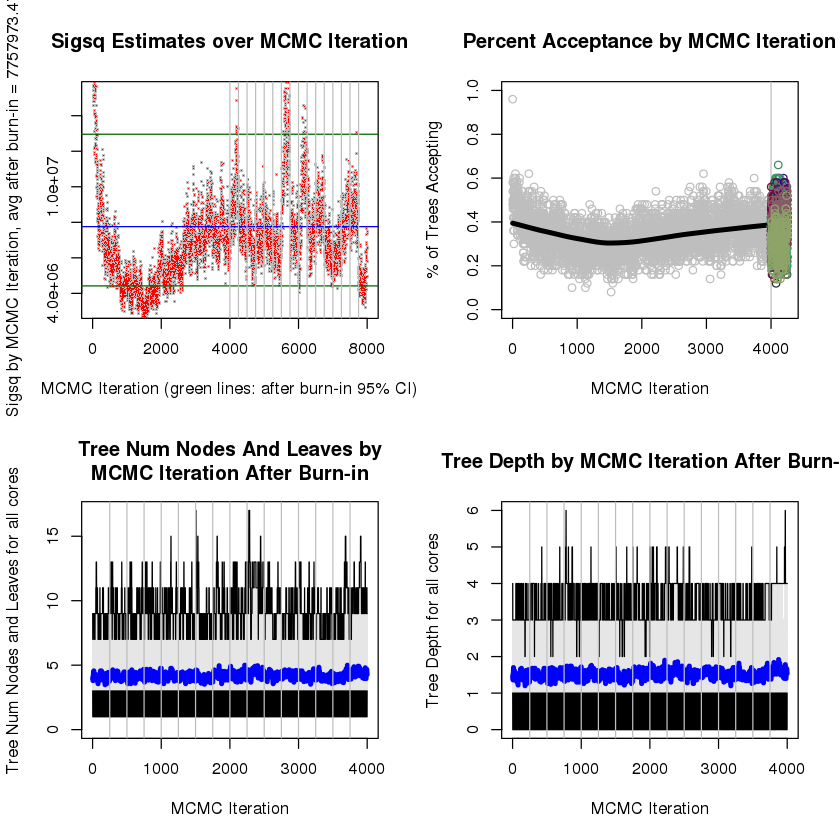

In [13]:
sim.dartmachine %>% plot_convergence_diagnostics

....................


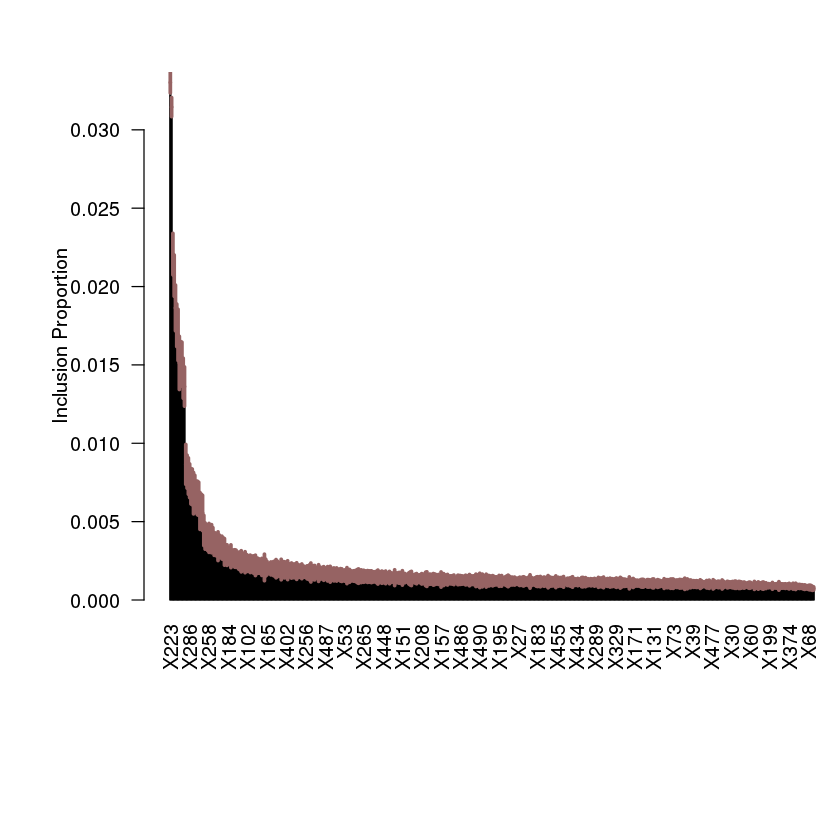

In [14]:
investigate_var_importance(sim.dartmachine, num_replicates_for_avg = 20)

In [15]:
saveRDS(sim.dartmachine,"model_files/simdartMachine_highdim_model_v1_20191124.RDS")
sim.dartmachine.read <- readRDS("model_files/simdartMachine_highdim_model_v1_20191124.RDS")
sim.dartmachine <- sim.dartmachine.read

# SoftBART with 500 Predictors, 5 important

In [22]:
library(SoftBart)

Loading required package: scales

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Loading required package: glmnet
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loaded glmnet 3.0-1

Loading required package: Rcpp


Finishing warmup 100 Number of trees = 50
Finishing warmup 200 Number of trees = 50
Finishing warmup 300 Number of trees = 50
Finishing warmup 400 Number of trees = 50
Finishing warmup 500 Number of trees = 50
Finishing warmup 600 Number of trees = 50
Finishing warmup 700 Number of trees = 50
Finishing warmup 800 Number of trees = 50
Finishing warmup 900 Number of trees = 50
Finishing warmup 1000 Number of trees = 50
Finishing warmup 1100 Number of trees = 50
Finishing warmup 1200 Number of trees = 50
Finishing warmup 1300 Number of trees = 50
Finishing warmup 1400 Number of trees = 50
Finishing warmup 1500 Number of trees = 50
Finishing warmup 1600 Number of trees = 50
Finishing warmup 1700 Number of trees = 50
Finishing warmup 1800 Number of trees = 50
Finishing warmup 1900 Number of trees = 50
Finishing warmup 2000 Number of trees = 50
Finishing warmup 2100 Number of trees = 50
Finishing warmup 2200 Number of trees = 50
Finishing warmup 2300 Number of trees = 50
Finishing warmup 240

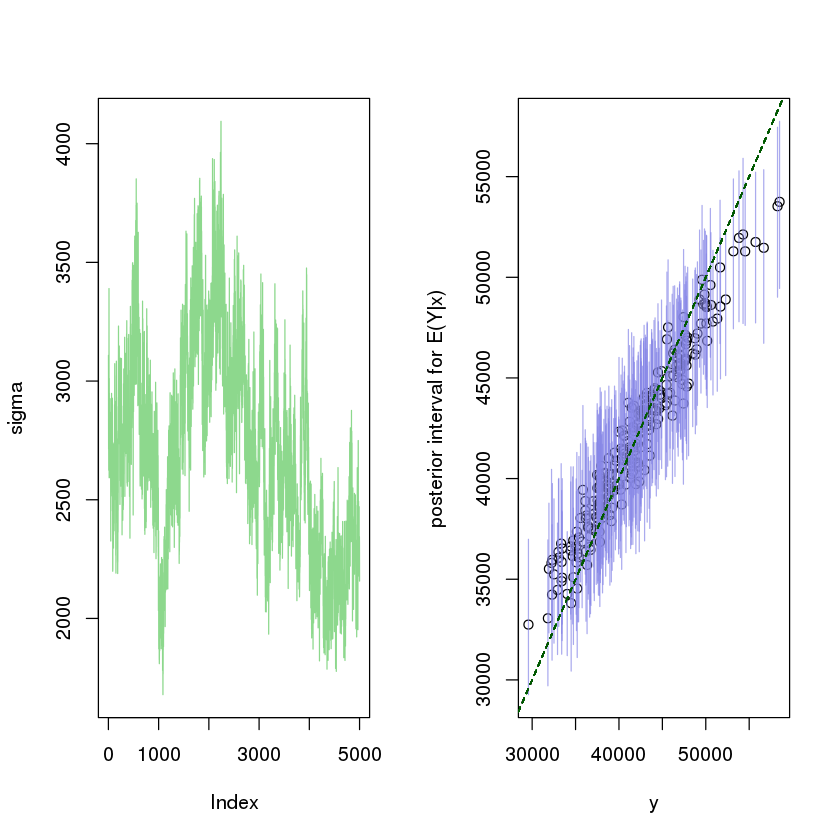

In [23]:
## Fit the models
softbart_fit_1 <- softbart(X = sim_data$X, Y = sim_data$Y, X_test = sim_data$X_test, 
                hypers = Hypers(sim_data$X, sim_data$Y, num_tree = 50, temperature = 1),
                opts = Opts(num_burn = 5000, num_save = 5000, update_tau = TRUE))

plot(softbart_fit_1)

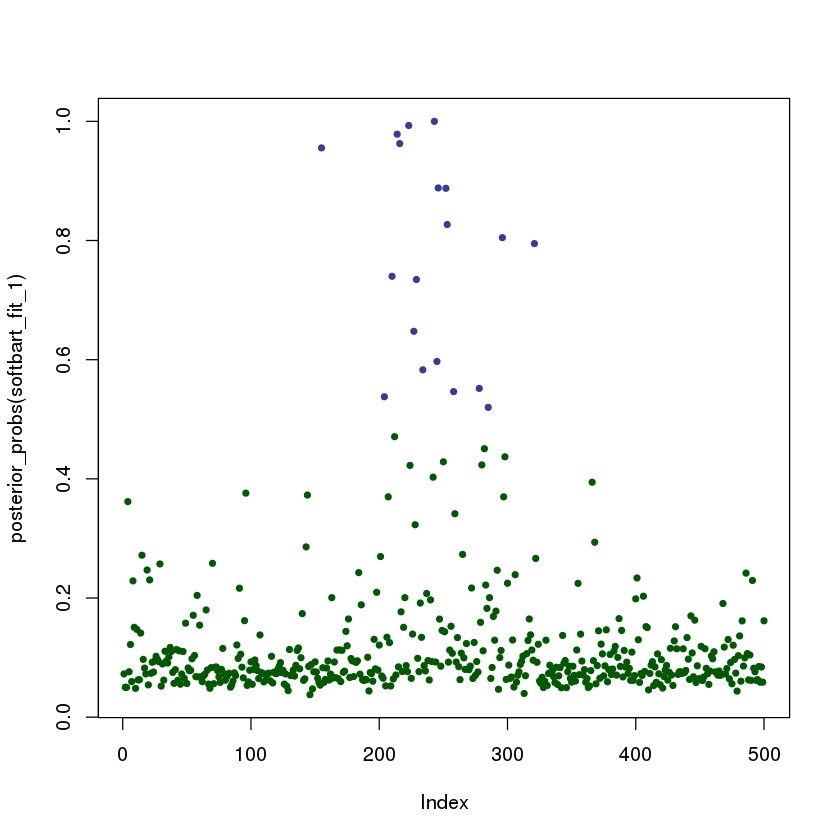

In [24]:
## Look at posterior model inclusion probabilities for each predictor. 

posterior_probs <- function(fit) colMeans(fit$var_counts > 0)
plot(posterior_probs(softbart_fit_1), 
     col = ifelse(posterior_probs(softbart_fit_1) > 0.5, muted("blue"), muted("green")), 
     pch = 20)

rmse <- function(x,y) sqrt(mean((x-y)^2))

In [25]:
rmse(softbart_fit_1$y_hat_train_mean, sim_data$Y)
rmse(softbart_fit_1$y_hat_test_mean, sim_data$Y_test)

[1] 1707.803

[1] 4461.244

In [26]:
saveRDS(softbart_fit_1,file = "model_files/softbart_highdim_model_20191124.RDS")

In [27]:
softbart_fit_1.read = readRDS("model_files/softbart_highdim_model_20191124.RDS")
softbart_fit_1 <- softbart_fit_1.read